# Homework 1
Pratham Mehta 

09/15/2025

Worked with Baanee Raheja (agx6xm) to review a few questions

## Question 2

In [10]:
## Import libraries

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd  # for convenience with some summaries
import numpy as np

print("import successful")


import successful


In [11]:
# load and clean data
filepath = "cook_social_2020.csv"
df = pl.read_csv(filepath)

# Convert datetime column to proper datetime type
df = df.with_columns(
    pl.col("datetime").str.to_datetime(strict=False)
)

# Remove unknown beetles
bad_values = ['UK', 'UKM', 'UKF']
df = df.filter(
    (~pl.col("focal_id").is_in(bad_values)) &
    (~pl.col("partner_id").is_in(bad_values))
)

# Filter to year 2020 only
df_2020 = df.filter(pl.col("datetime").dt.year() == 2020)


In [12]:
df_2020.head(20)

datetime,condo,focal_id,sex,behavior,grid_cell,cell_location,partner_id,partner_interaction
"datetime[μs, UTC]",str,str,str,str,str,str,str,str
2020-08-03 06:39:00 UTC,"""1A""","""2N9""","""M""","""G""","""C10""","""C""","""5LT""","""Mating Partners"""
2020-08-03 06:39:00 UTC,"""1A""","""5LT""","""F""","""G""","""C10""","""C""","""2N9""","""Mating Partners"""
2020-08-03 06:45:00 UTC,"""1A""","""2OL""","""M""","""S""","""LEG""",null,"""4AT""","""5 CM Partners"""
2020-08-03 06:45:00 UTC,"""1A""","""2OL""","""M""","""S""","""LEG""",null,"""3NF""","""5 CM Partners"""
2020-08-03 06:45:00 UTC,"""1A""","""4AT""","""M""","""CRT""","""LEG""",null,"""3NF""","""Mating Partners"""
…,…,…,…,…,…,…,…,…
2020-08-03 07:04:00 UTC,"""1B""","""5YK""","""F""","""S""","""A10""","""C""","""4OS""","""5 CM Partners"""
2020-08-03 07:04:00 UTC,"""1B""","""5TA""","""F""","""S""","""A10""","""C""","""5YK""","""5 CM Partners"""
2020-08-03 07:04:00 UTC,"""1B""","""5TA""","""F""","""S""","""A10""","""C""","""4OS""","""5 CM Partners"""


### Constructing Behavioral Networks

In [13]:
# ----------------------------
# Helper function: Build network by condo
# ----------------------------
def build_networks(df, interaction_type):
    """
    Build networks for each condo for a given interaction type.
    Returns a dictionary: {condo: nx.Graph}
    """
    condo_graphs = {}
    # filter by interaction type
    df_sub = df.filter(pl.col("partner_interaction") == interaction_type)

    # loop over condos
    for condo in df_sub["condo"].unique():
        df_c = df_sub.filter(pl.col("condo") == condo)

        # build graph
        G = nx.Graph()
        for row in df_c.iter_rows(named=True):
            G.add_edge(row["focal_id"], row["partner_id"])
        condo_graphs[condo] = G
    
    return condo_graphs

# Build networks
proximity_networks = build_networks(df_2020, "5 CM Partners")
touch_networks     = build_networks(df_2020, "Touch Partners")  
mating_networks    = build_networks(df_2020, "Mating Partners")


### Network Stats for Each Graph

In [14]:
# ----------------------------
# Helper function: Get network stats
# ----------------------------
def network_stats(graphs_dict):
    """
    Compute stats across condos:
    nodes, edges, min/mean/max degree, density, clustering coefficient
    """
    stats = []
    for condo, G in graphs_dict.items():
        if len(G) == 0:
            continue
        degrees = [deg for _, deg in G.degree()]
        stats.append({
            "condo": condo,
            "nodes": G.number_of_nodes(),
            "edges": G.number_of_edges(),
            "min_degree": np.min(degrees),
            "max_degree": np.max(degrees),
            "mean_degree": np.mean(degrees),
            "density": nx.density(G),
            "clustering": nx.average_clustering(G)   # <--- NEW
        })
    return pd.DataFrame(stats)

# Get stats
stats_proximity = network_stats(proximity_networks)
stats_touch     = network_stats(touch_networks)
stats_mating    = network_stats(mating_networks)

# Combine into one table
all_stats = pd.concat([
    stats_proximity.assign(network="Proximity"),
    stats_touch.assign(network="Touch"),
    stats_mating.assign(network="Mating")
])

# Average across condos (numeric columns only)
summary_stats = (
    all_stats
    .groupby("network")
    .mean(numeric_only=True)
    .reset_index()
)

print(summary_stats.to_string(index=False))


  network     nodes      edges  min_degree  max_degree  mean_degree  density  clustering
   Mating 32.166667  75.833333    1.083333    9.500000     4.676386 0.149738    0.000000
Proximity 34.666667 137.583333    1.250000   14.916667     7.938462 0.236001    0.321209
    Touch 28.500000  42.083333    1.000000    7.916667     2.922189 0.106184    0.147903


The average degree follows as proximity > mating > touch. Proximity having the highest averge degree makes sense because it has the last strict criteria; it is just two beetles in the same vicinity. The ReadME doesn't explain the differences between the three categories, but from our data, it is fair to assume that touch has the most strict criteria.

The clustering coefficient for mating is there are no closed triangles. There are nodes connected to each other, but not in a closed triangle. Proximity and touch on the other hand, have a small proportion of closed triangles, and therefore have nonzero clustering coefficients. I'm unsure as to what these could represent within the context of our data. 

C:\Users\prath\AppData\Local\Temp\ipykernel_18260\1471248261.py:10: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


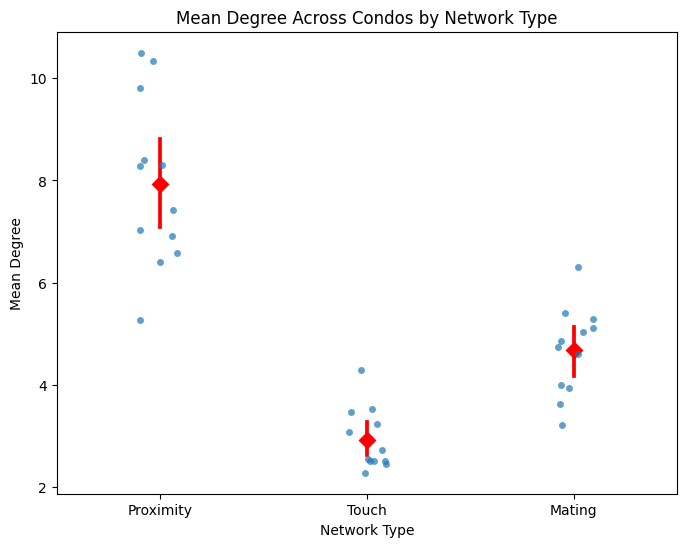

In [15]:
plt.figure(figsize=(8,6))
errorbar=('ci', 'False')

# Strip plot of condo-level mean degree
sns.stripplot(
    data=all_stats,
    x="network", y="mean_degree", jitter=True, alpha=0.7
)
# Overlay red diamonds showing the average across condos
sns.pointplot(
    data=all_stats,
    x="network", y="mean_degree", estimator="mean",
    color="red", markers="D", join=False
)

plt.title("Mean Degree Across Condos by Network Type")
plt.ylabel("Mean Degree")
plt.xlabel("Network Type")
plt.show()


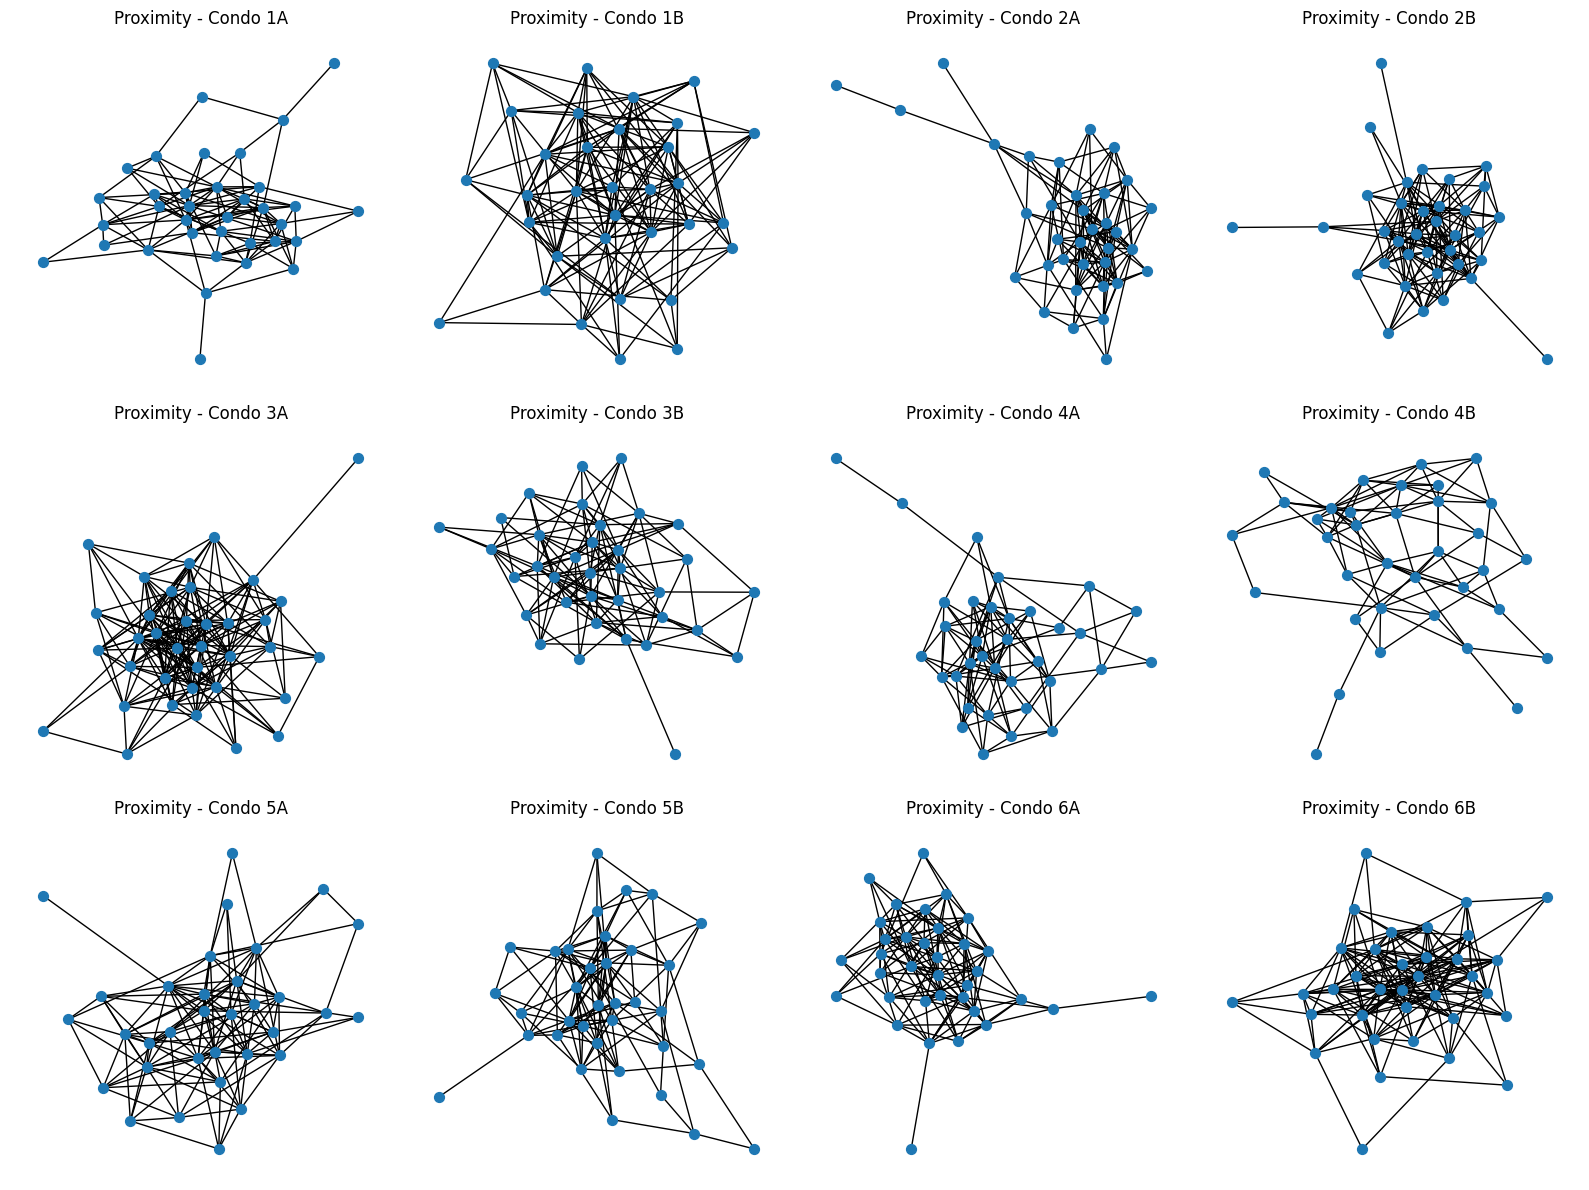

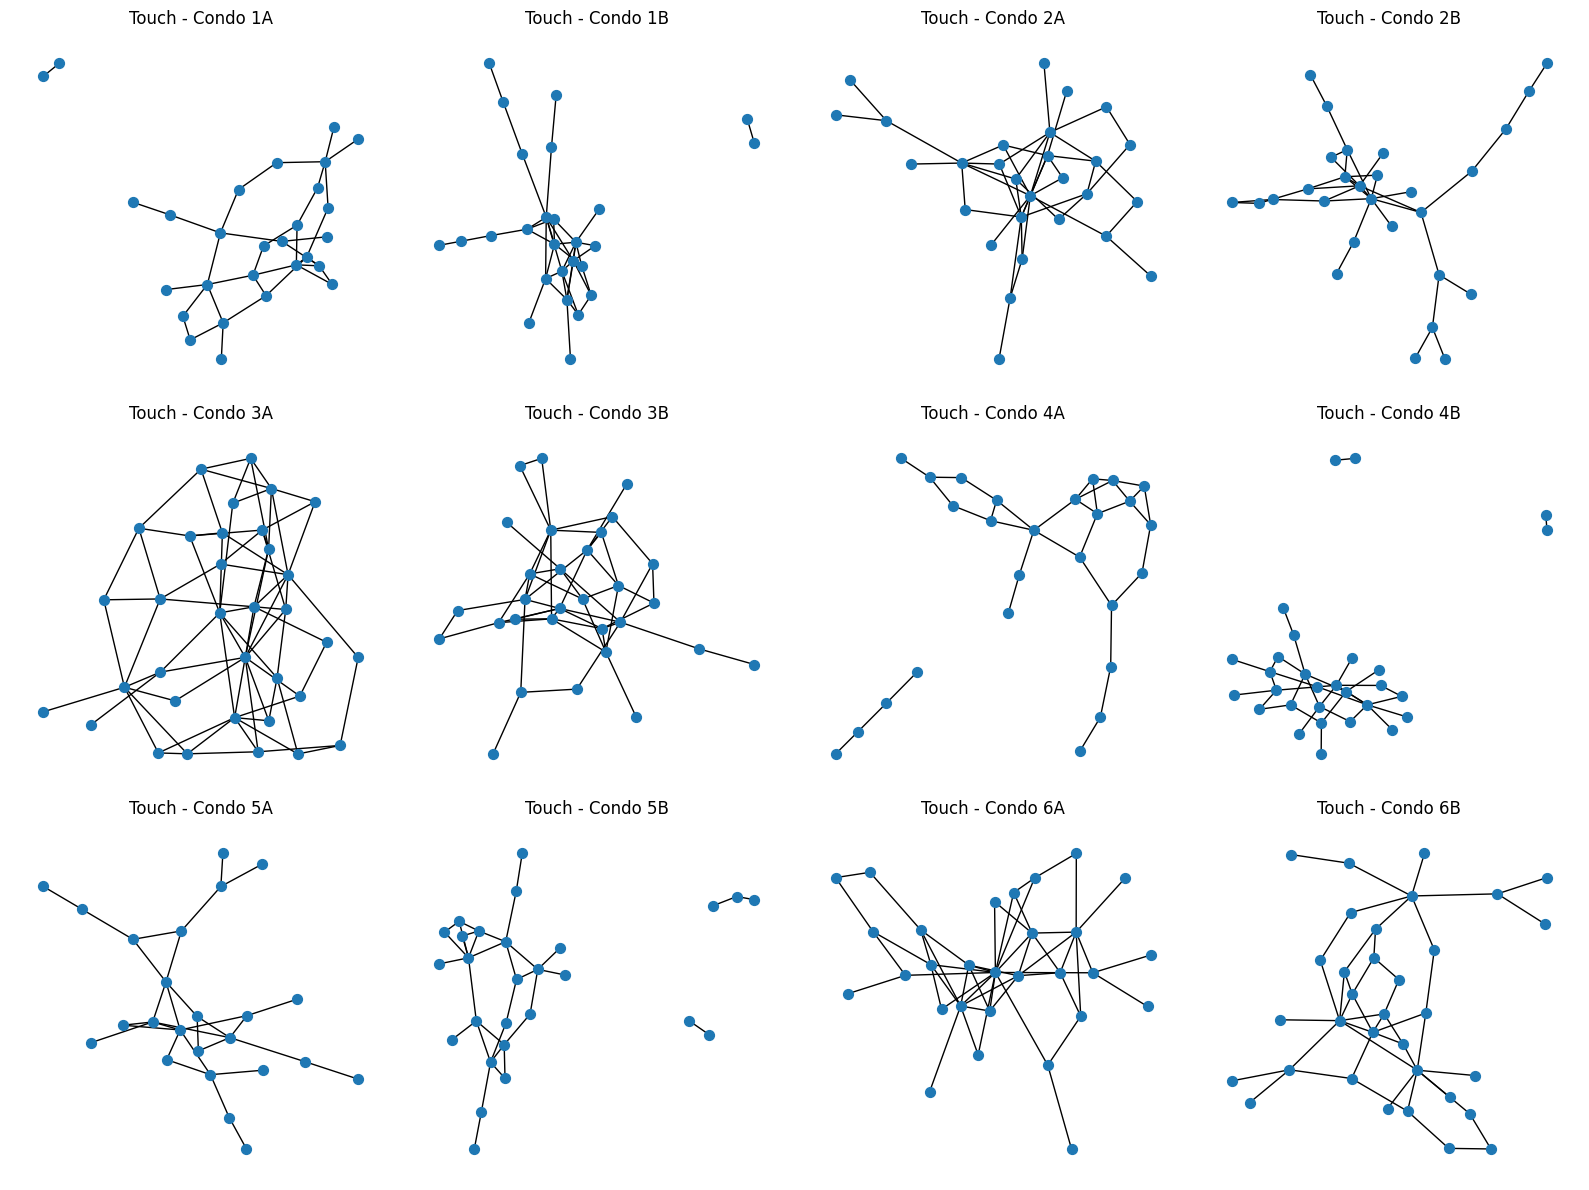

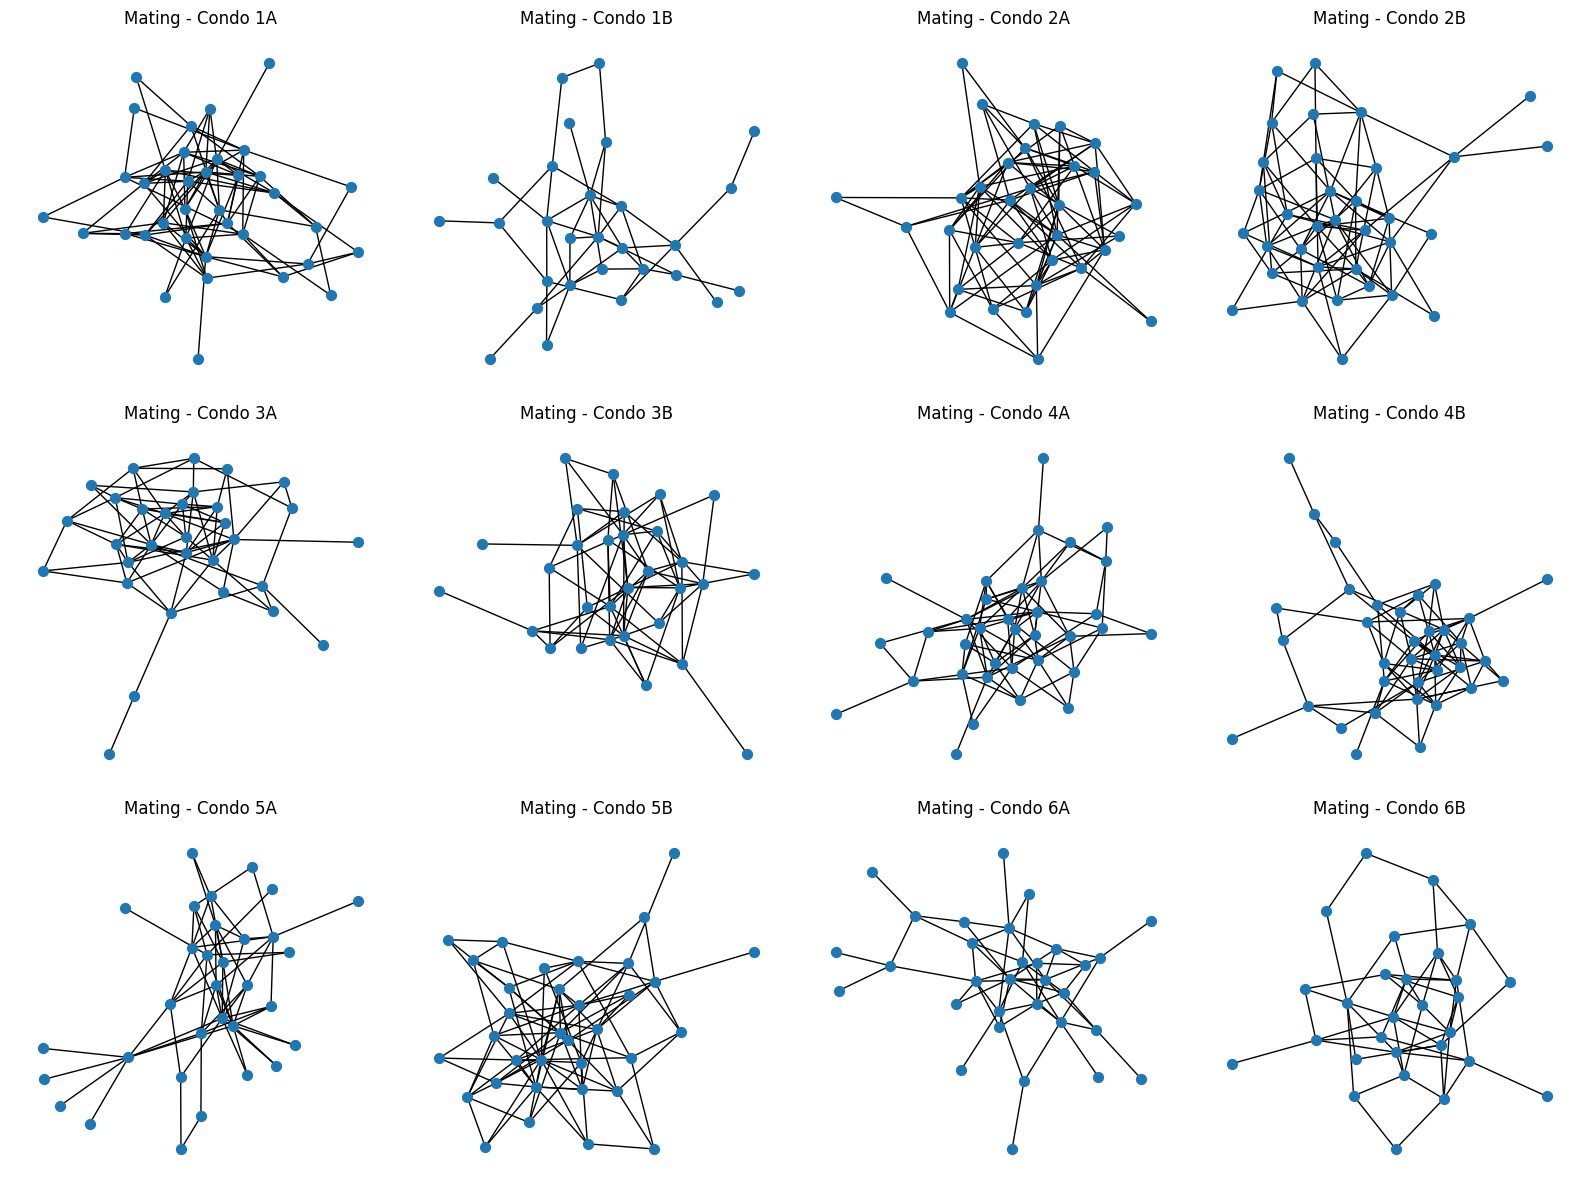

In [16]:
# ----------------------------
# Plot networks for each condo
# ----------------------------
def plot_networks(graphs_dict, title_prefix):
    fig, axes = plt.subplots(3, 4, figsize=(16,12))
    axes = axes.flatten()

    for i, (condo, G) in enumerate(sorted(graphs_dict.items())):
        H = G.copy()
        H.remove_nodes_from(list(nx.isolates(H)))  # remove isolated nodes
        nx.draw(H, ax=axes[i], node_size=50, with_labels=False)
        axes[i].set_title(f"{title_prefix} - Condo {condo}")
    plt.tight_layout()
    plt.show()

plot_networks(proximity_networks, "Proximity")
plot_networks(touch_networks, "Touch")
plot_networks(mating_networks, "Mating")


## Question 3

Directed Network - Edges: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5), (4, 1), (5, 1), (5, 2)]


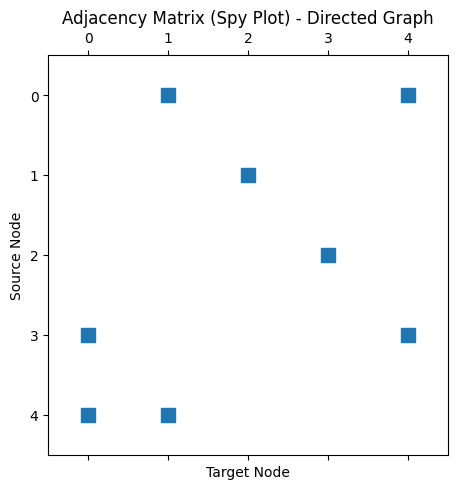

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# ======== Directed Network Setup ========

# Create a directed graph and add edges
directed_net = nx.DiGraph()
directed_edges = [
    (1, 2), (2, 3), (3, 4), (4, 5), (5, 1),
    (1, 5), (5, 2), (4, 1)
]
directed_net.add_edges_from(directed_edges)

print("Directed Network - Edges:", list(directed_net.edges()))

# Visualize the adjacency matrix using a spy plot
adjacency = nx.adjacency_matrix(directed_net)
plt.figure(figsize=(5, 5))
plt.spy(adjacency, markersize=10)
plt.title("Adjacency Matrix (Spy Plot) - Directed Graph")
plt.xlabel("Target Node")
plt.ylabel("Source Node")
plt.tight_layout()
plt.show()


Bipartite Graph - Edges: [(1, 7), (1, 8), (2, 7), (2, 9), (3, 8), (3, 10), (4, 9), (4, 11), (5, 10), (5, 11), (6, 11)]


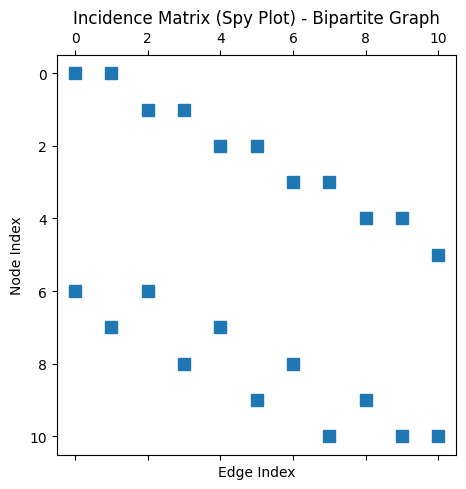

In [18]:
# ======== Bipartite Network Setup ========

# Create a bipartite undirected graph
bipartite_net = nx.Graph()

# Node groups: Group A (1-6) and Group B (7-11)
red = range(1, 7)
black = range(7, 12)

bipartite_net.add_nodes_from(red, bipartite=0)
bipartite_net.add_nodes_from(black, bipartite=1)

# Define the bipartite edges
bipartite_edges = [
    (7, 1), (7, 2),
    (8, 1), (8, 3),
    (9, 2), (9, 4),
    (10, 3), (10, 5),
    (11, 4), (11, 5), (11, 6)
]
bipartite_net.add_edges_from(bipartite_edges)

print("\nBipartite Graph - Edges:", list(bipartite_net.edges()))

# Compute and display the incidence matrix
incidence = nx.incidence_matrix(bipartite_net)
plt.figure(figsize=(6, 5))
plt.spy(incidence, markersize=8)
plt.title("Incidence Matrix (Spy Plot) - Bipartite Graph")
plt.xlabel("Edge Index")
plt.ylabel("Node Index")
plt.tight_layout()
plt.show()